In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [35]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [36]:

import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import History
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [37]:
# import opendatasets as od


In [38]:
# Assign the Kaggle data set URL into variable
# dataset = 'https://www.kaggle.com/datasets/hs181001/bk-isut-dataset'
# Using opendatasets let's download the data sets
# od.download(dataset)

In [39]:
import keras
keras.__version__

'2.14.0'

In [40]:
import segmentation_models as sm

In [41]:
import albumentations as A

In [42]:
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, running on CPU instead.")

TensorFlow version: 2.14.0
Pandas version: 2.1.1
Numpy version: 1.26.0
1 Physical GPUs, 1 Logical GPUs


In [43]:
save_train_image_dataset_path = './bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = './bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = './bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = './bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = './bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = './bk-isut-dataset/mask_test_image_dataset.npy'

In [44]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [45]:
# Define the augmentation function
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=0),
        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0, value=0),
        A.RandomCrop(height=height, width=width, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

In [46]:
# Function to apply augmentation
def augment_data(image, mask):
    aug = get_training_augmentation(256, 256)(image=image, mask=mask)
    aug_image = aug['image'].astype(np.uint8)
    aug_mask = aug['mask'].astype(np.uint8)
    return aug_image, aug_mask

# Wrap the augmentation function for TensorFlow
def tf_augment_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=augment_data, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
    return aug_img, aug_mask

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [48]:
def _normalize(X_batch, y_batch):
  X_batch = tf.cast(X_batch, tf.float32)
  y_batch = tf.cast(y_batch, tf.float32)
  return X_batch, y_batch


In [49]:
# Create augmented dataset
augmented_train_dataset = train_dataset.map(tf_augment_data)

In [50]:
# Combine normal and augmented datasets
combined_train_dataset = train_dataset.concatenate(augmented_train_dataset)

In [51]:
# Normalize and batch the datasets
train_dataset = combined_train_dataset.map(_normalize).batch(16)
val_dataset = val_dataset.batch(16).map(_normalize)

In [52]:
checkpoint_path = "unet_resnet34_pretrained/cp.weights.h5"

In [53]:
BACKBONE1 = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE1)

# preprocess input
train_dataset = preprocess_input(train_dataset)
val_dataset = preprocess_input(val_dataset)


In [54]:
model = sm.Unet('resnet34', classes=5, activation='softmax')
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

In [55]:
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)

In [56]:
callbacks = [
   #  tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
]


# model = tf.keras.models.load_model('my_model_with_batch_image.keras')
history = model.fit(
   train_dataset,
   epochs=100,
   validation_data=val_dataset,
   callbacks=callbacks,
)

Epoch 1/200
389/390 [============================>.] - ETA: 0s - loss: 0.4131 - iou_score: 0.4603
Epoch 1: val_loss improved from inf to 0.30981, saving model to dice_loss_resnet34_backbone_updated/cp.weights.h5
390/390 [==============================] - 36s 76ms/step - loss: 0.4131 - iou_score: 0.4603 - val_loss: 0.3098 - val_iou_score: 0.5810
Epoch 2/200
389/390 [============================>.] - ETA: 0s - loss: 0.3377 - iou_score: 0.5369
Epoch 2: val_loss did not improve from 0.30981
390/390 [==============================] - 29s 74ms/step - loss: 0.3379 - iou_score: 0.5361 - val_loss: 0.3469 - val_iou_score: 0.5398
Epoch 3/200
389/390 [============================>.] - ETA: 0s - loss: 0.3158 - iou_score: 0.5601
Epoch 3: val_loss improved from 0.30981 to 0.30756, saving model to dice_loss_resnet34_backbone_updated/cp.weights.h5
390/390 [==============================] - 29s 75ms/step - loss: 0.3158 - iou_score: 0.5597 - val_loss: 0.3076 - val_iou_score: 0.5860
Epoch 4/200
389/390 [=

In [67]:
# model.load_weights(checkpoint_path)

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


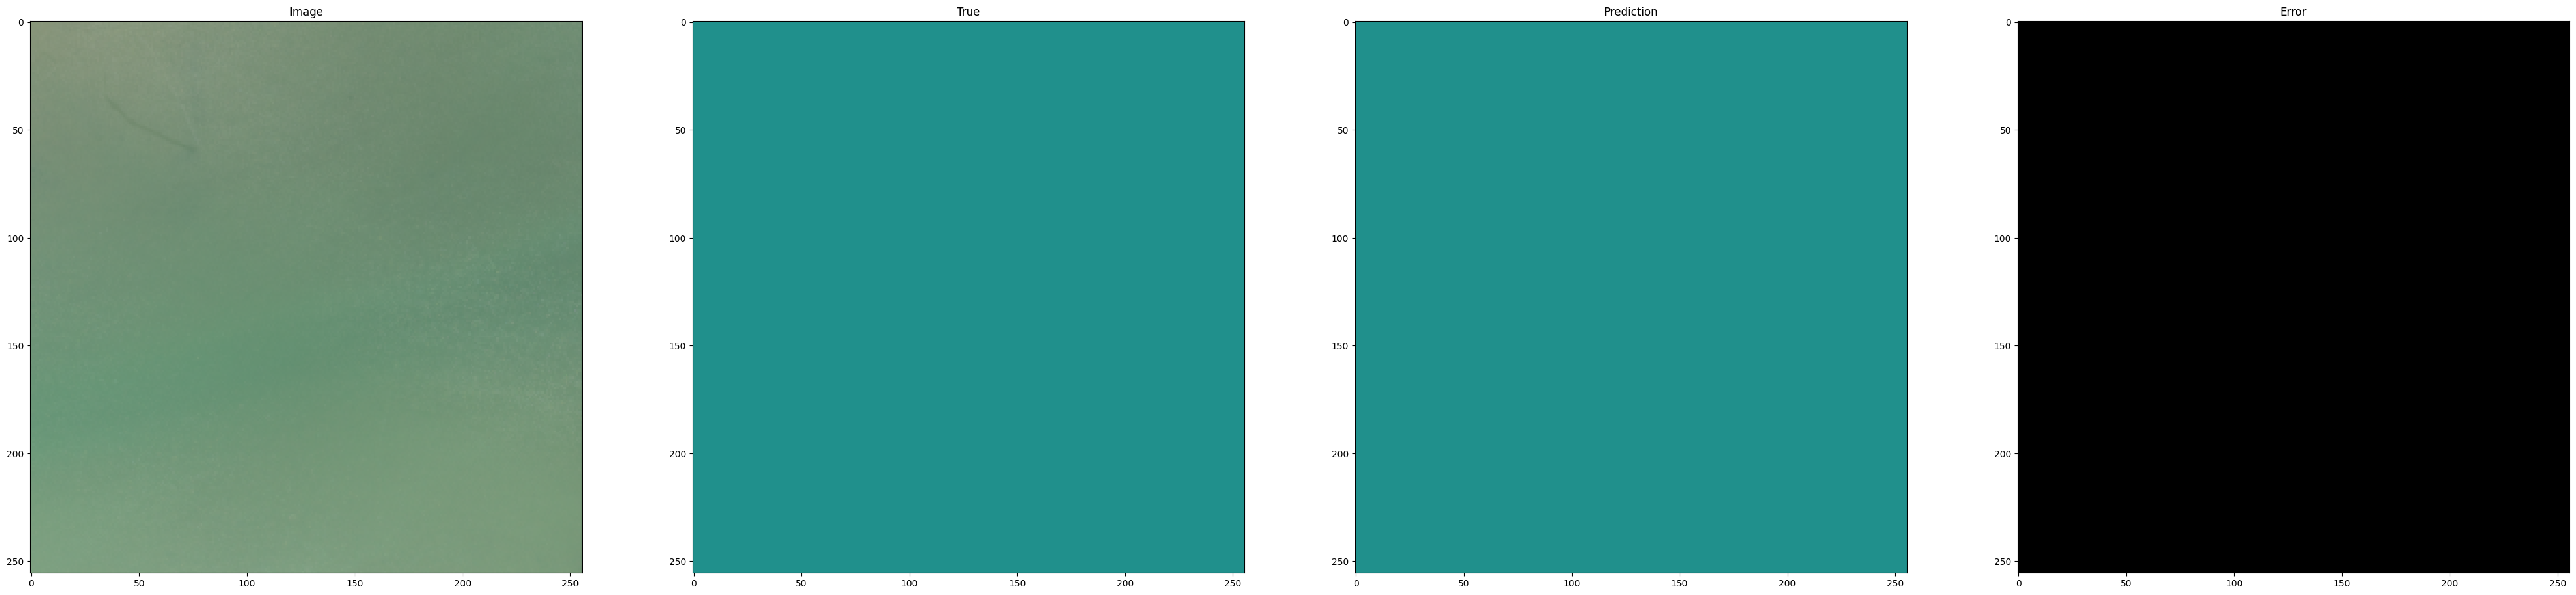

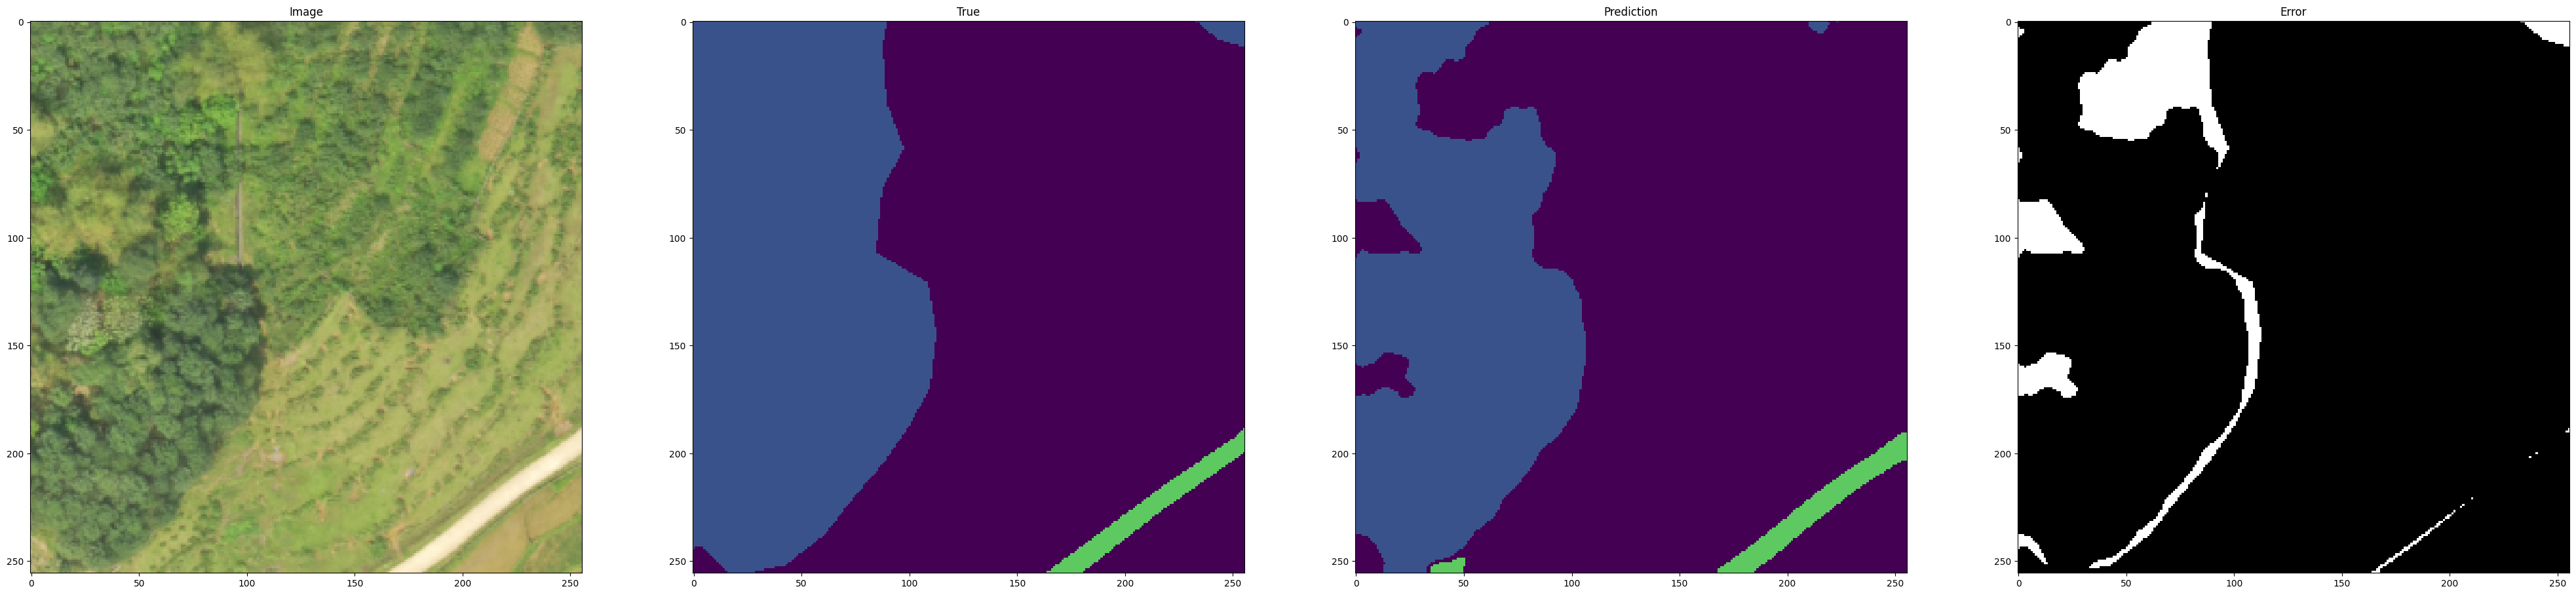

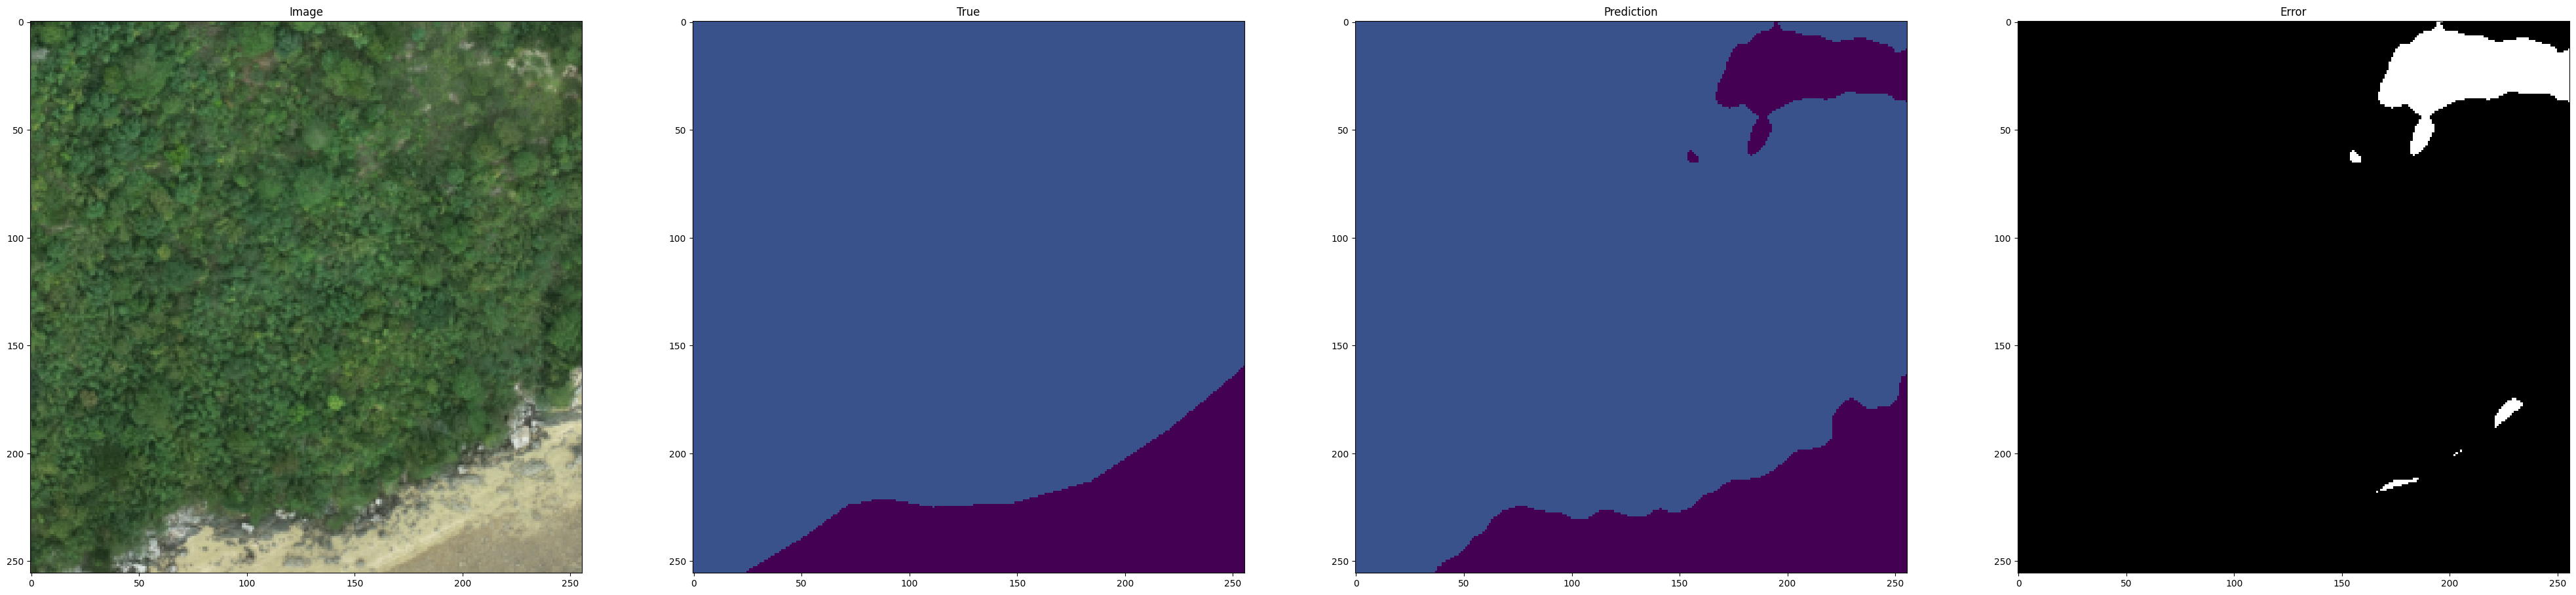

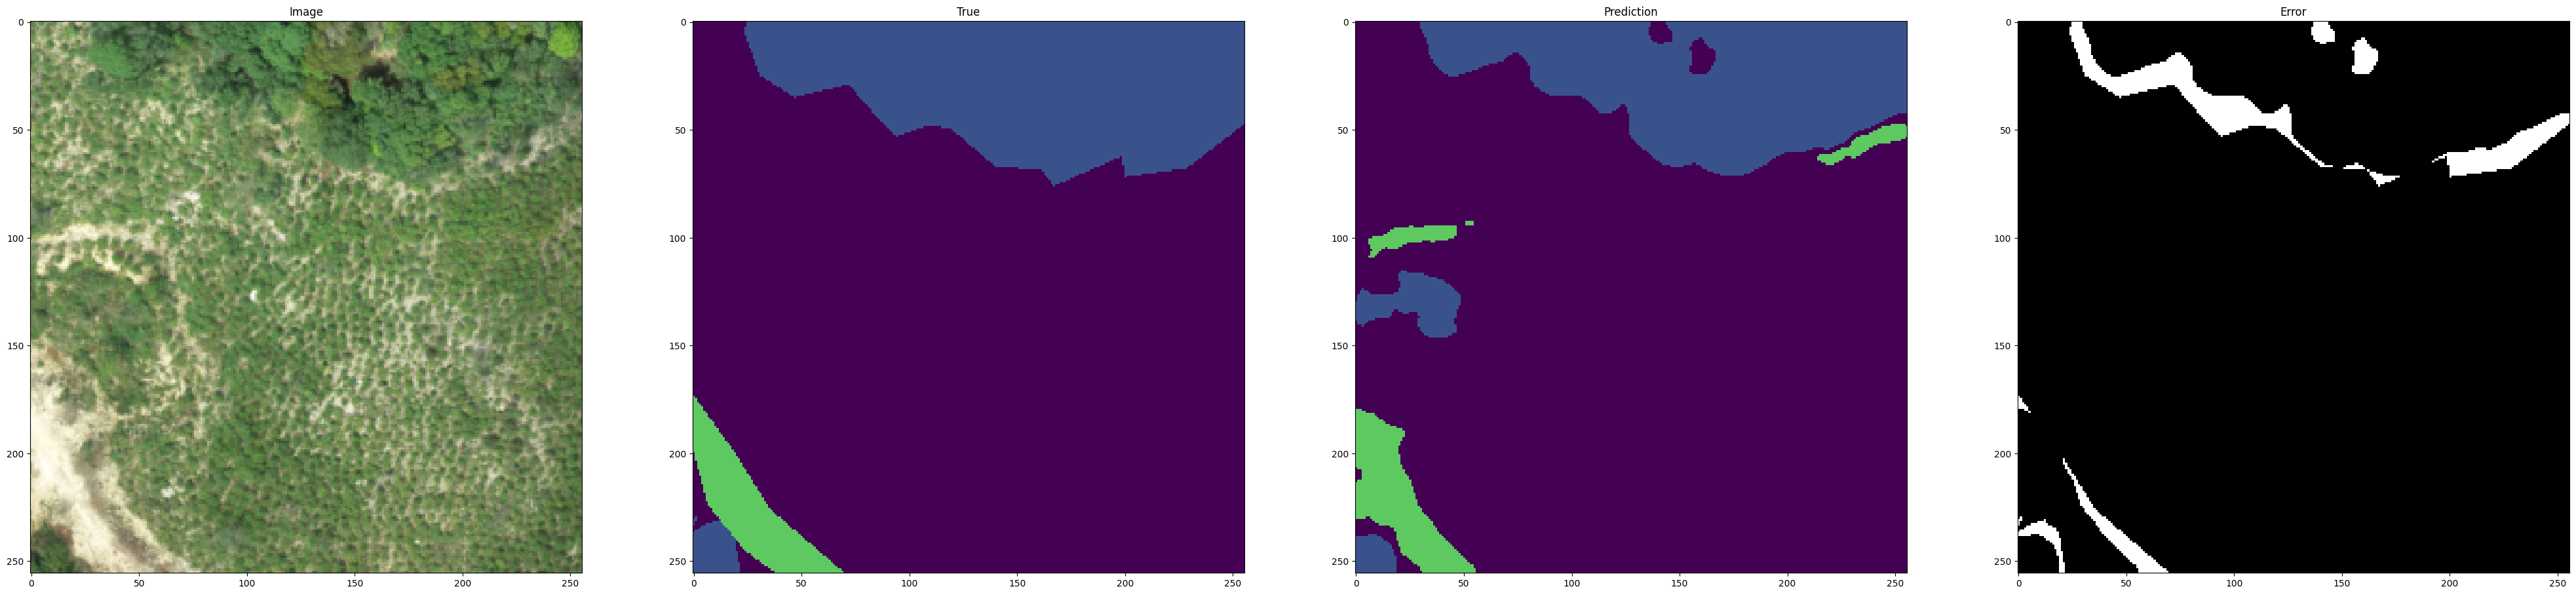

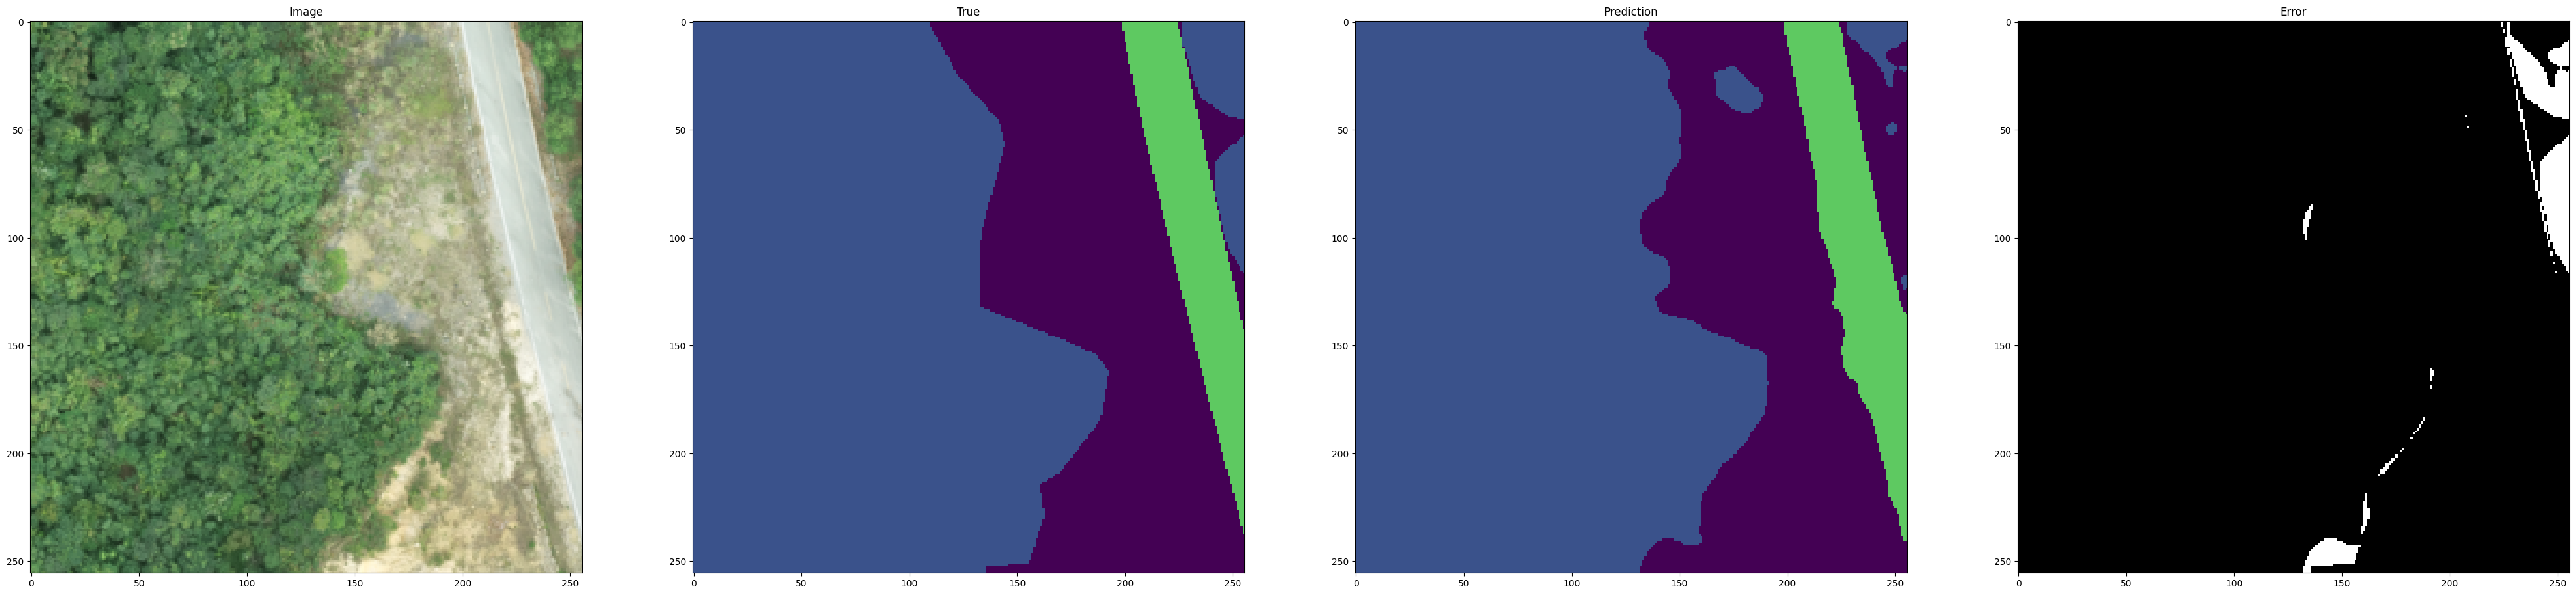

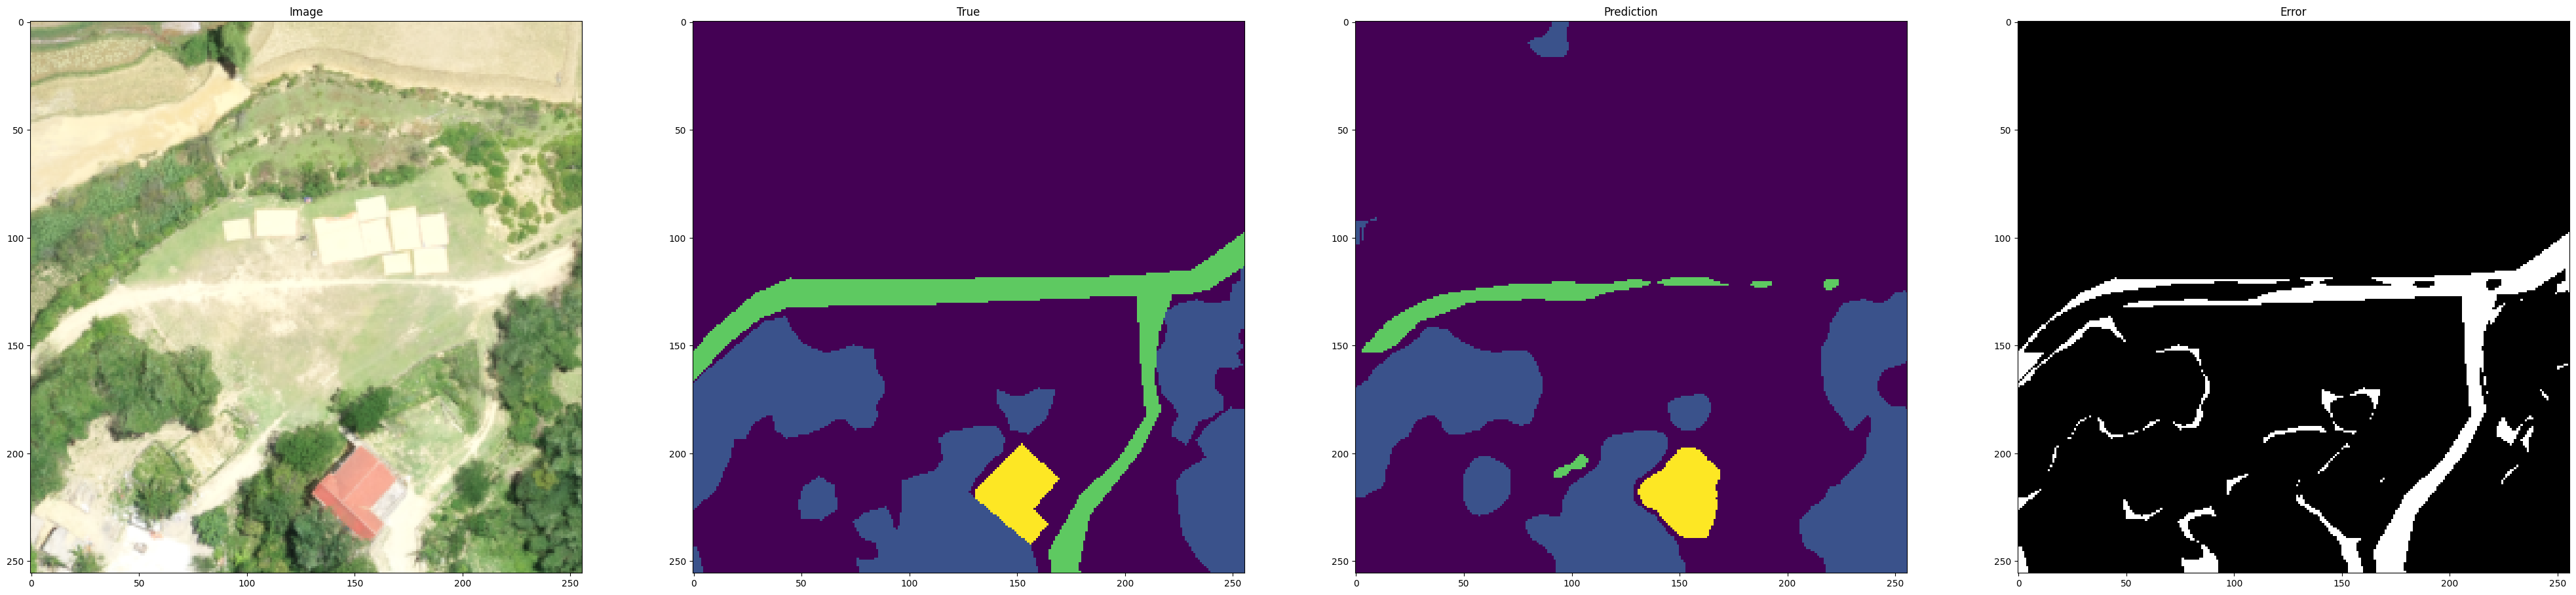

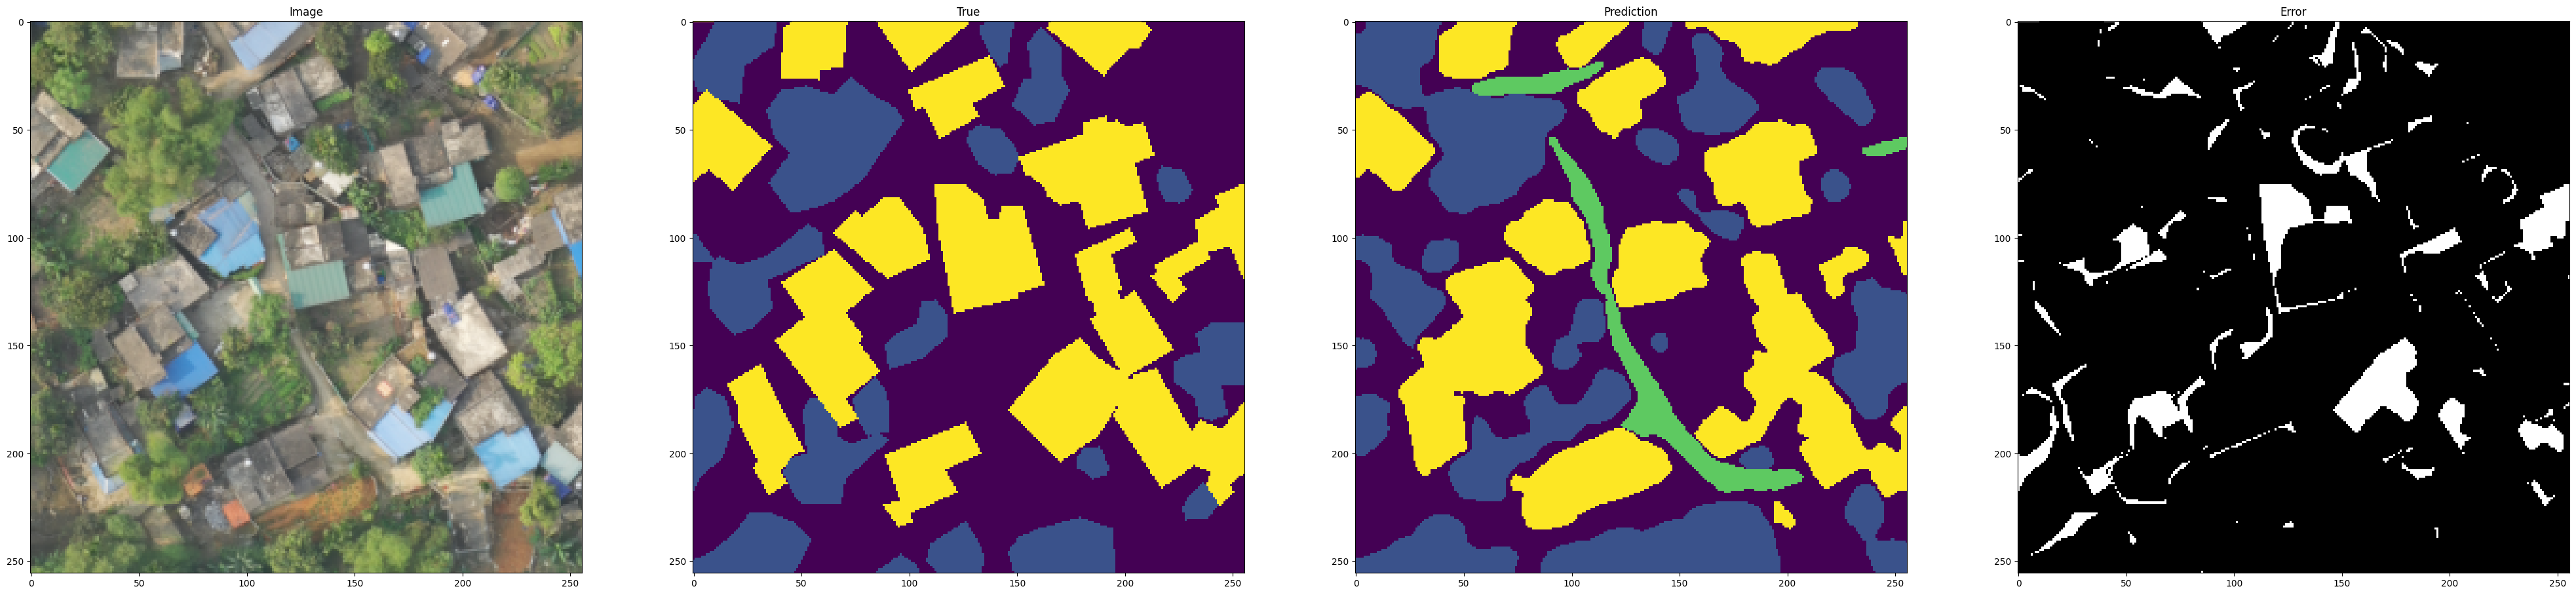

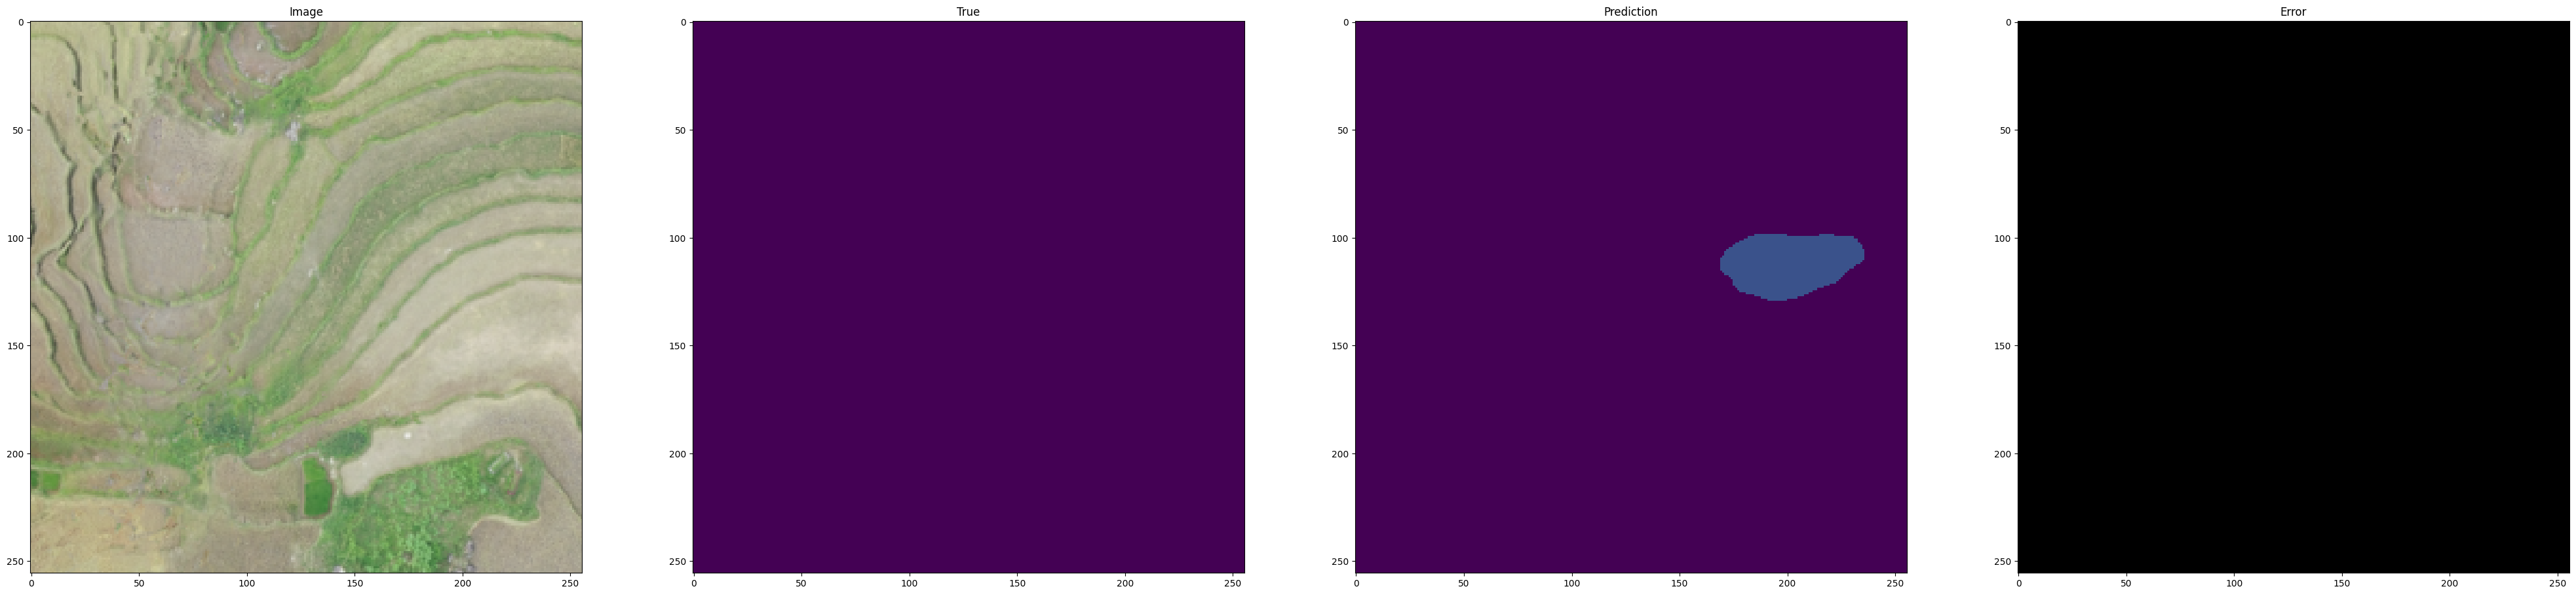

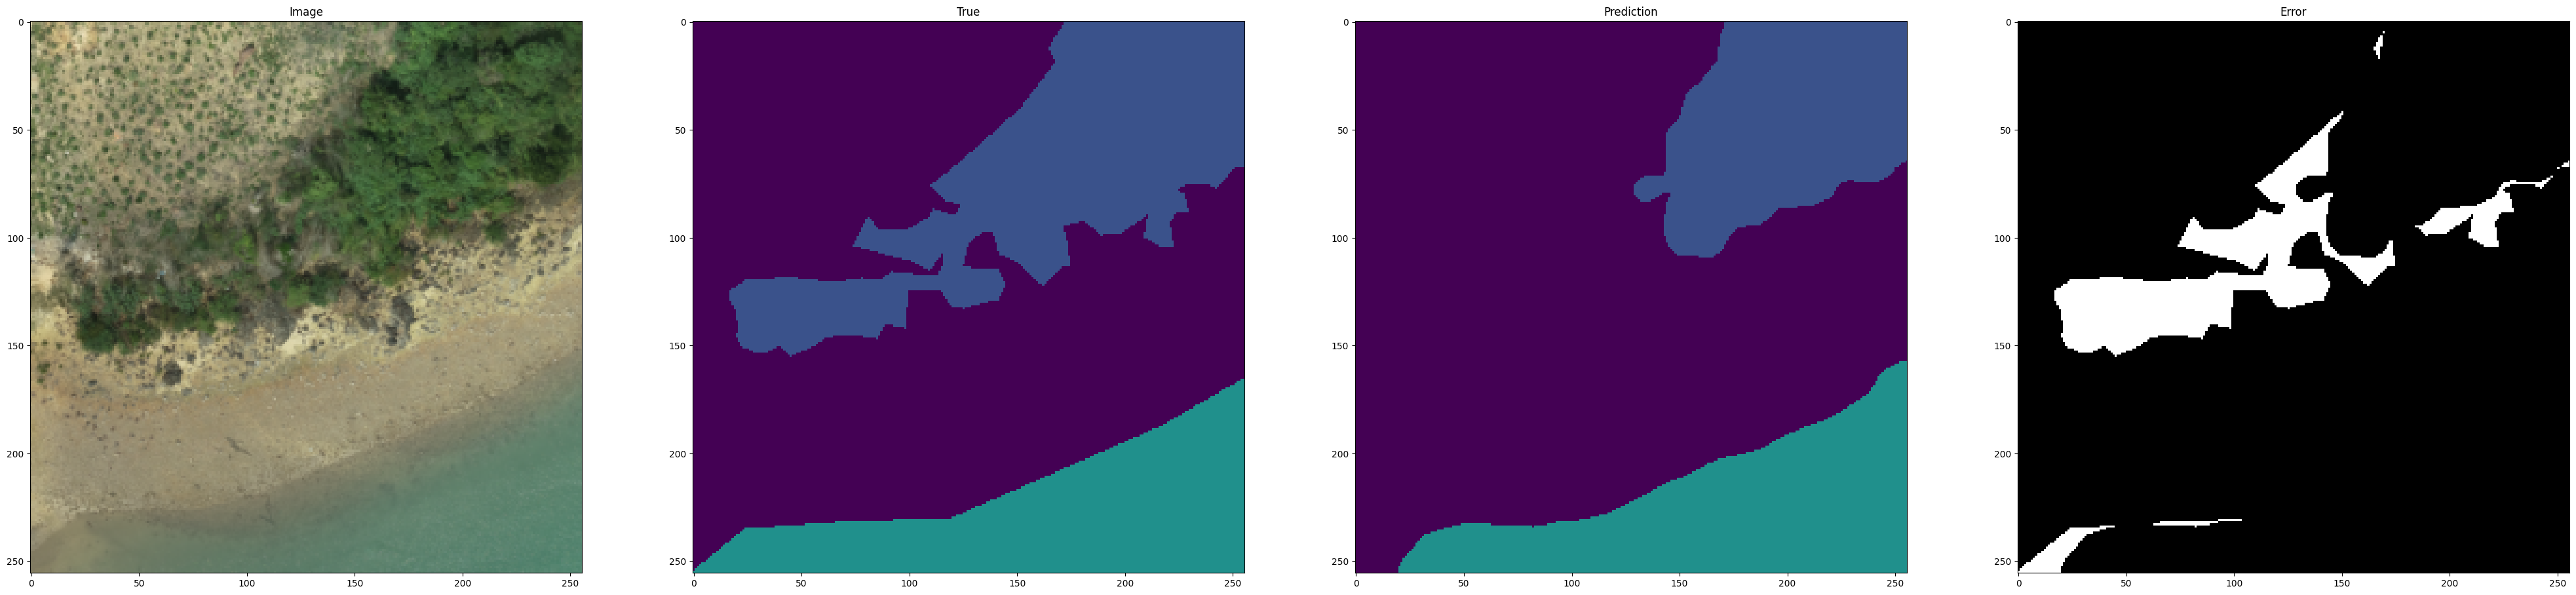

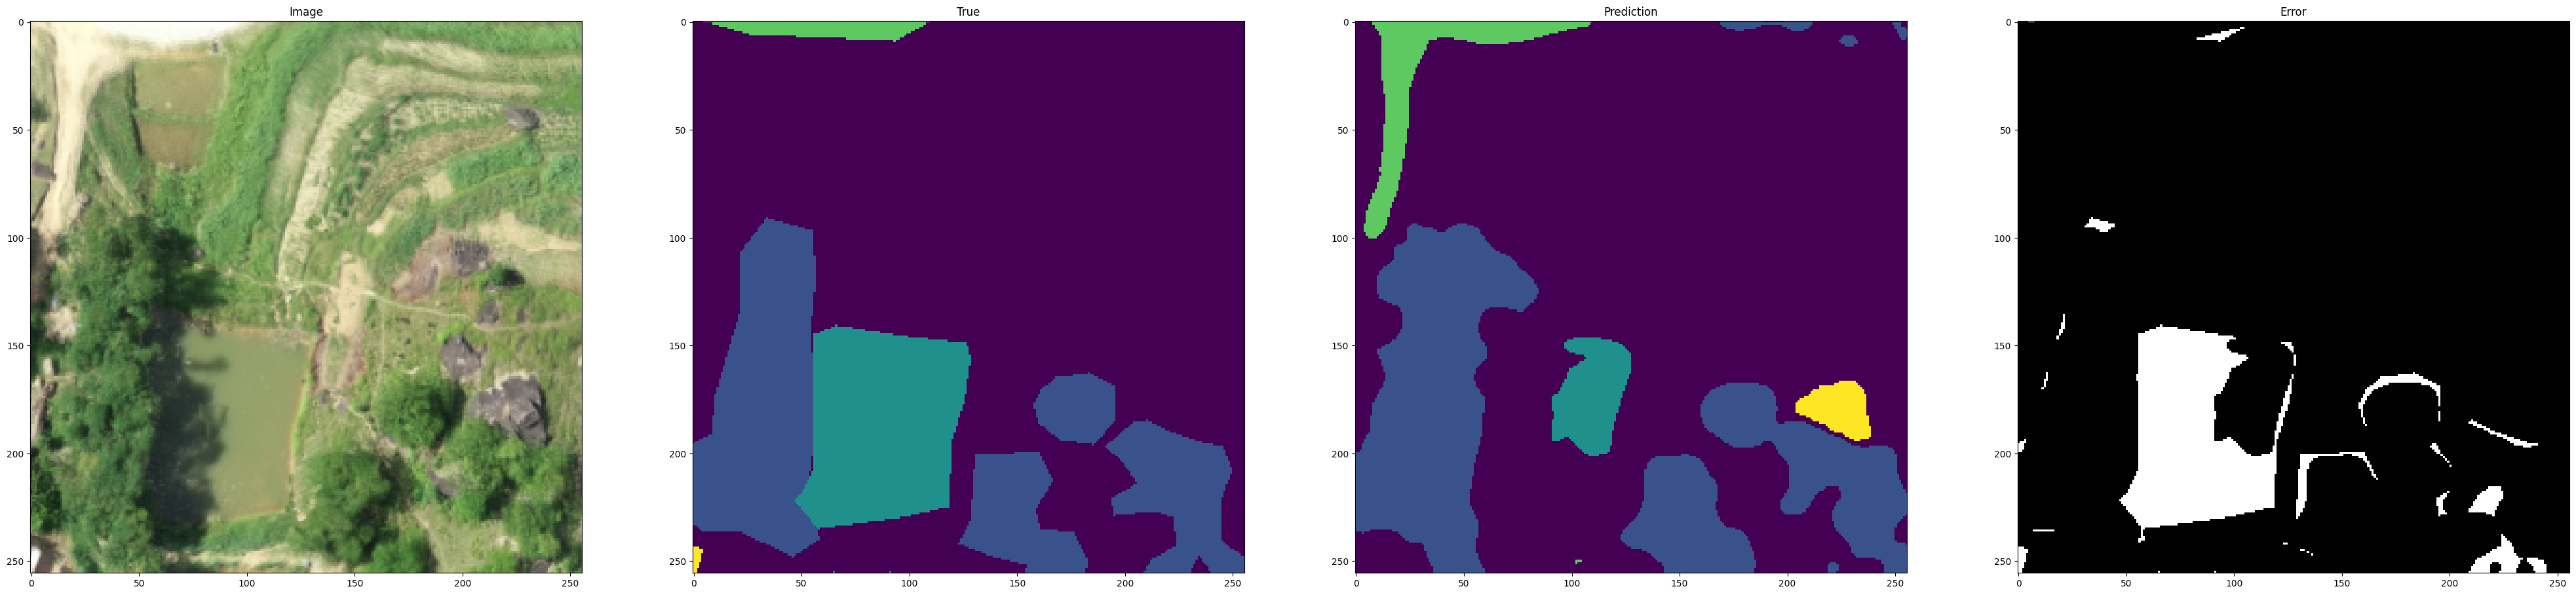

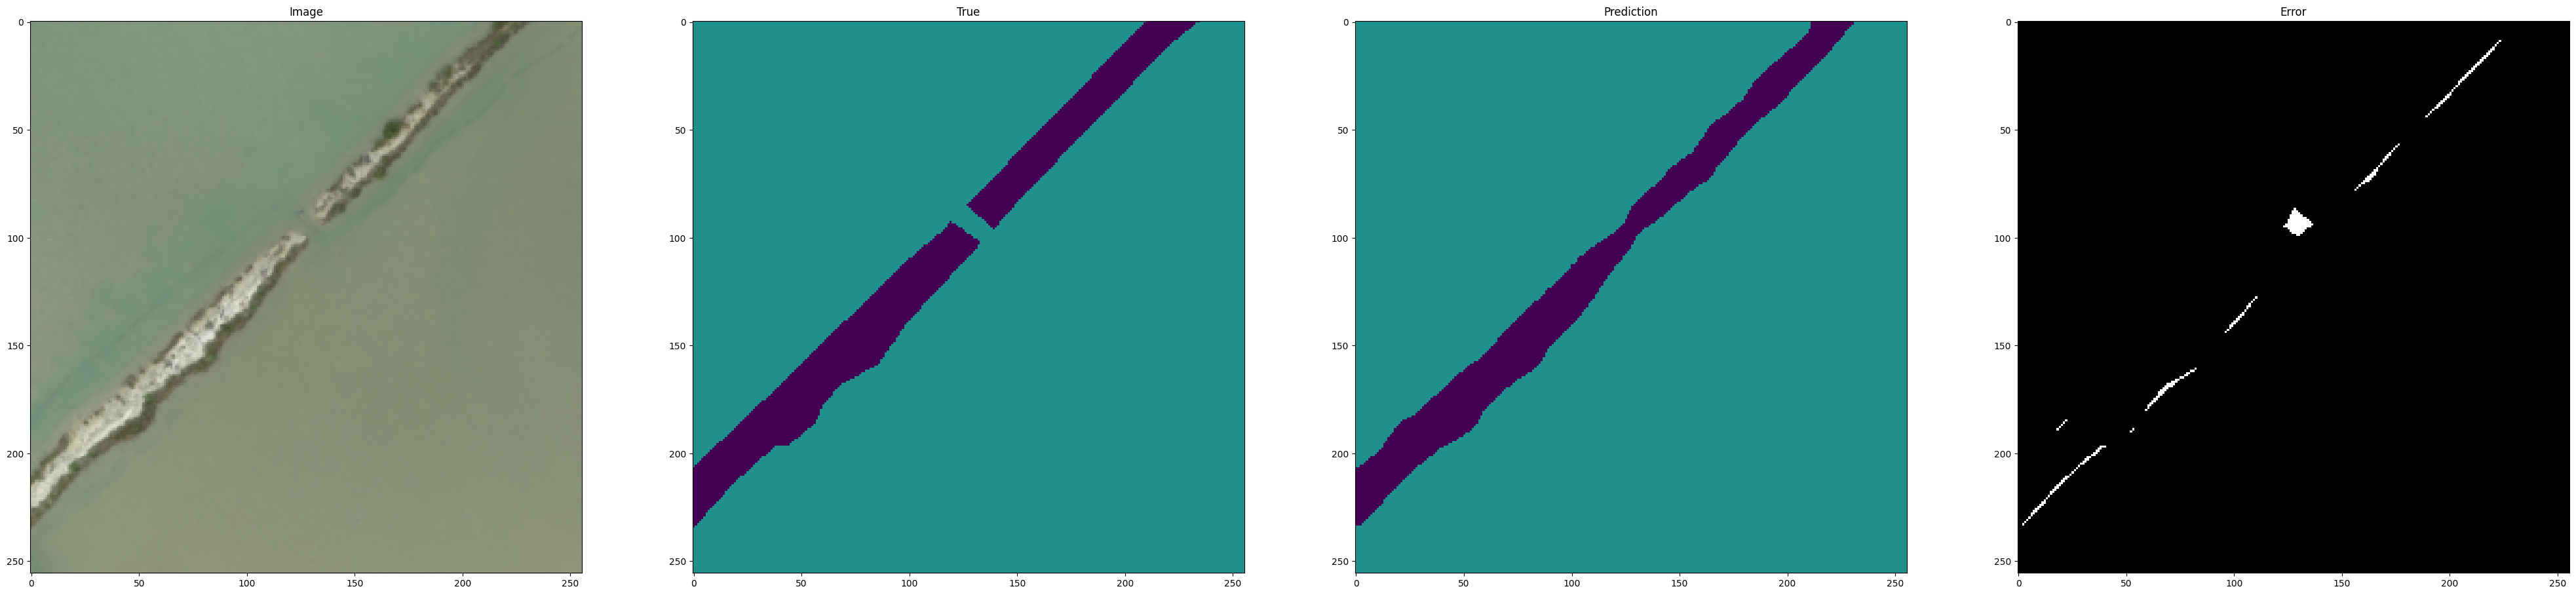

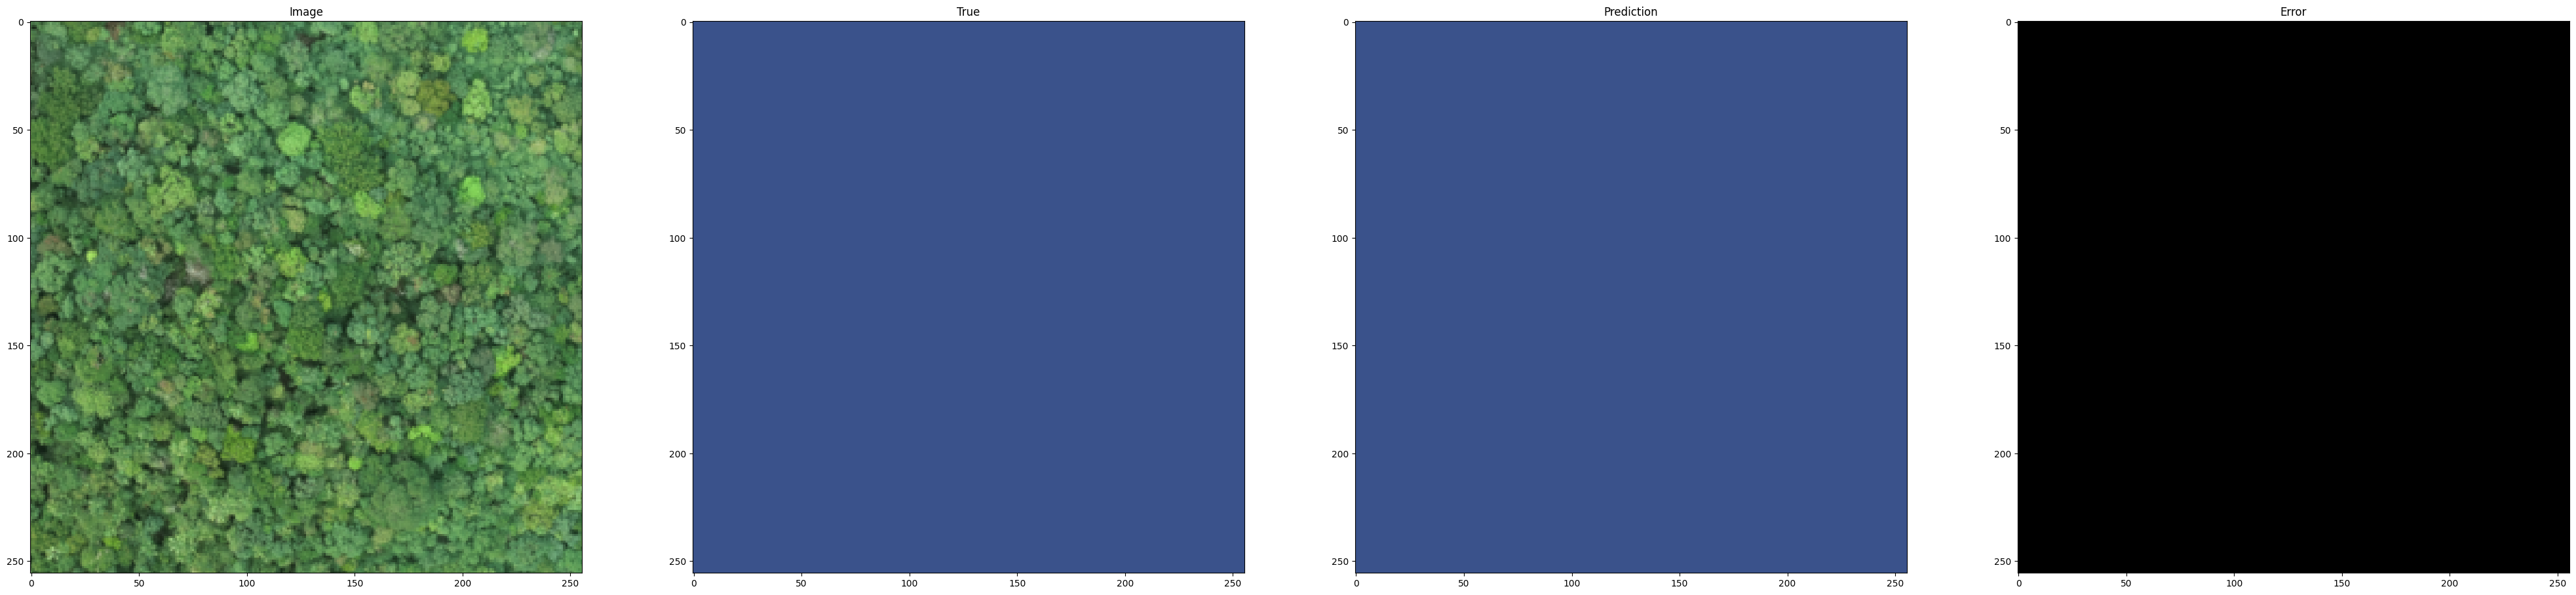

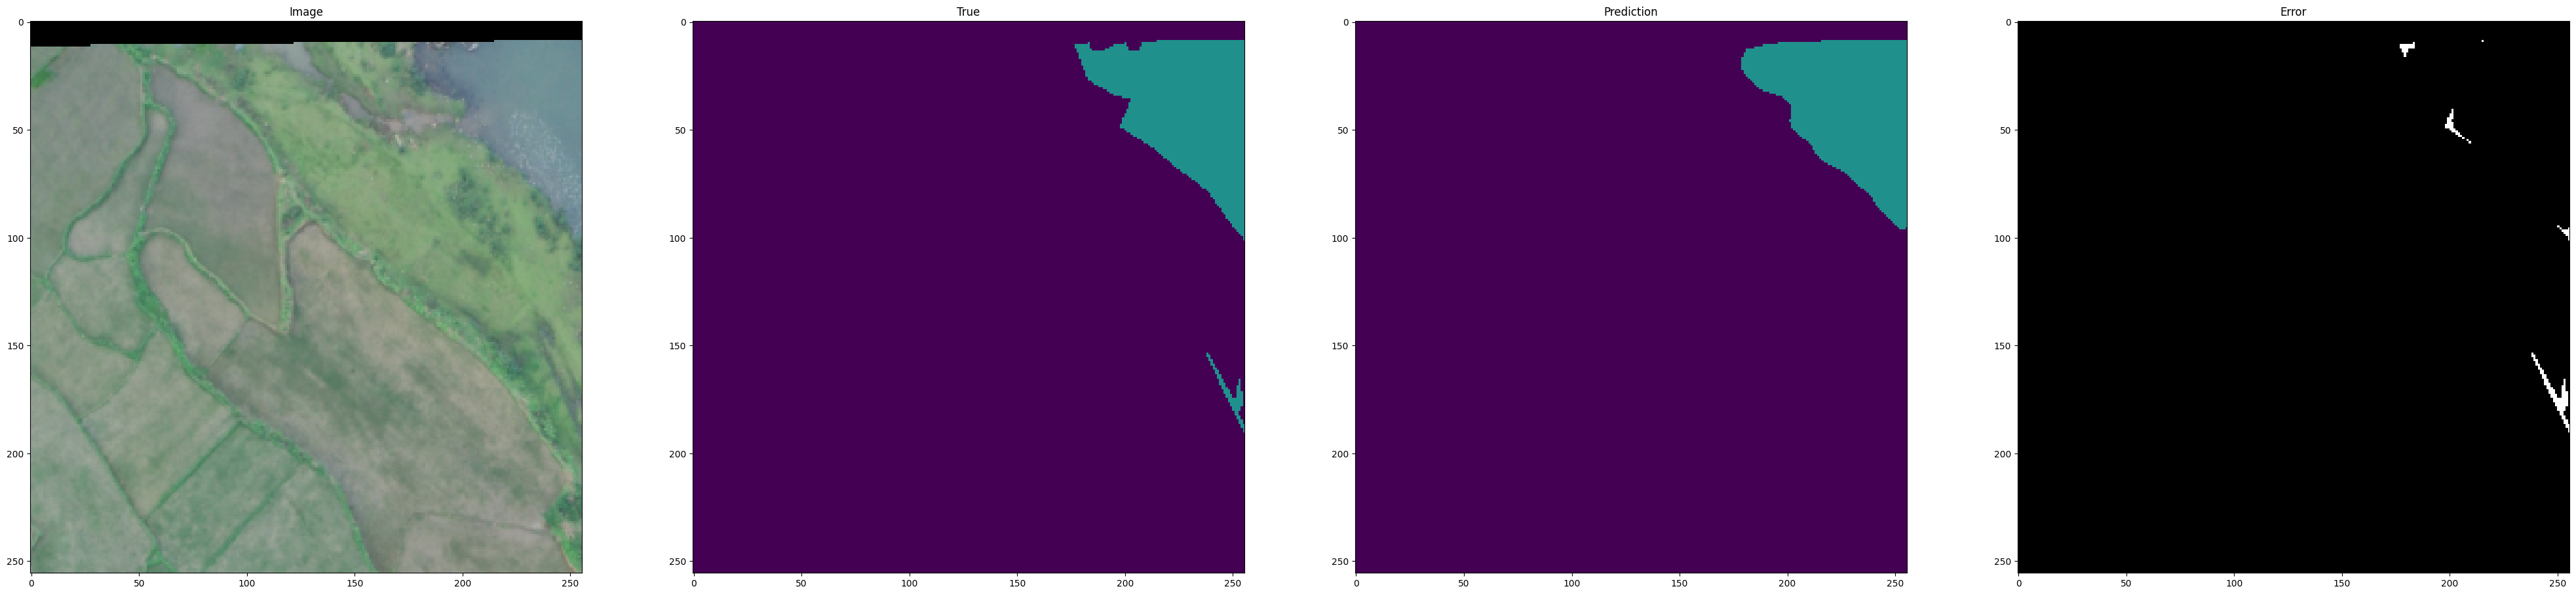

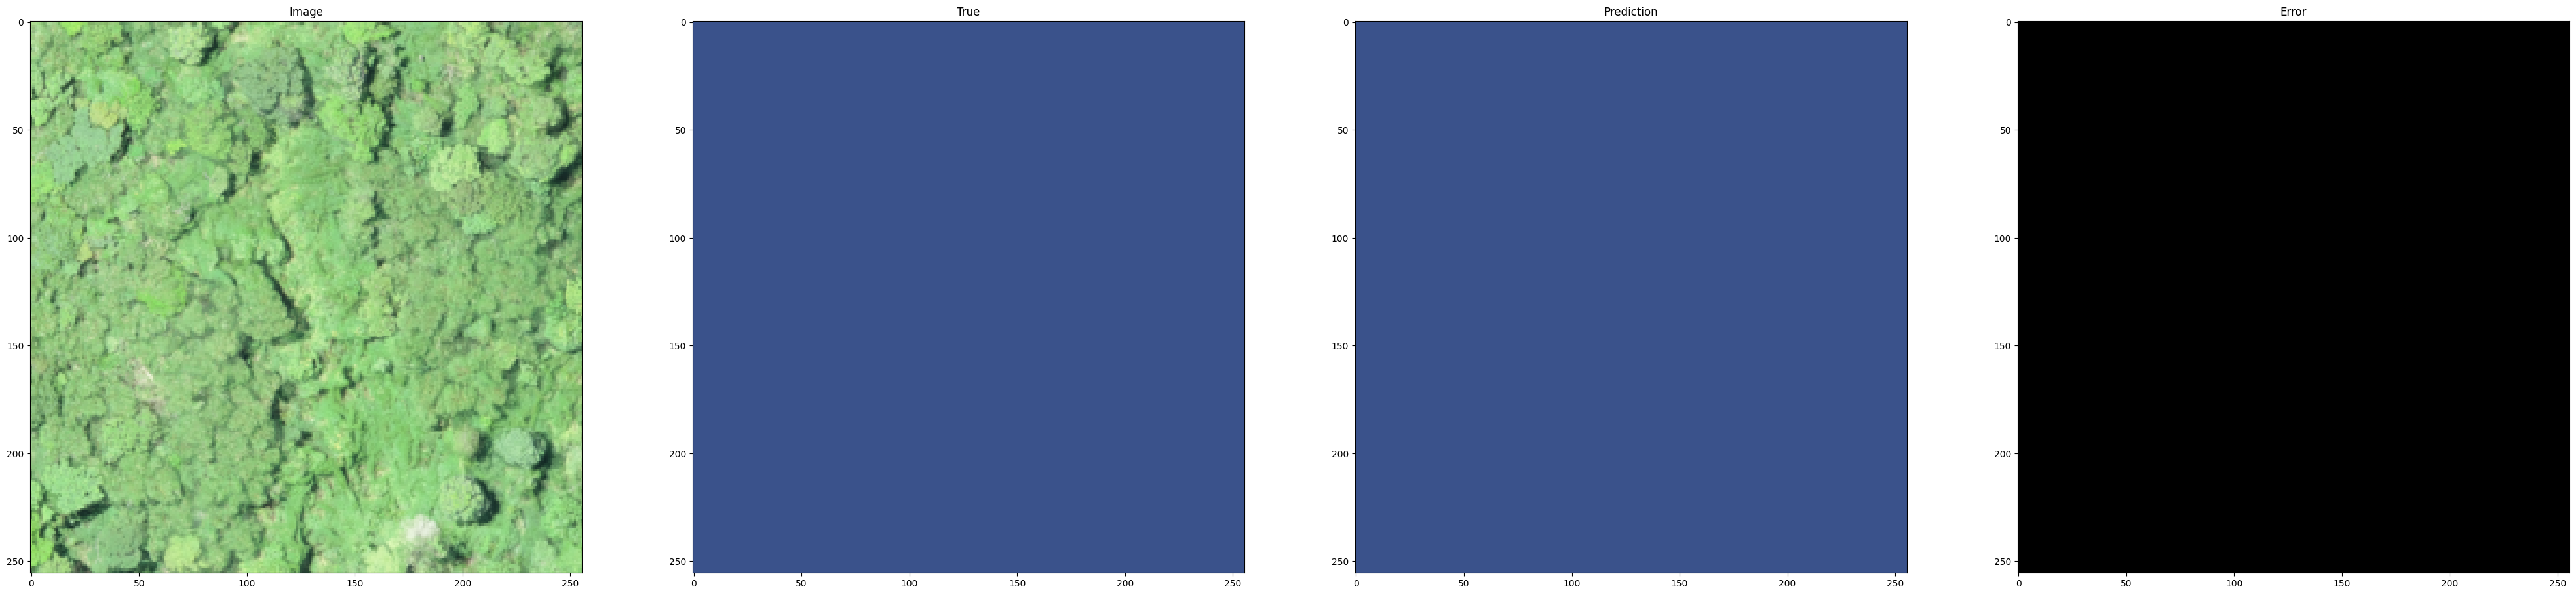

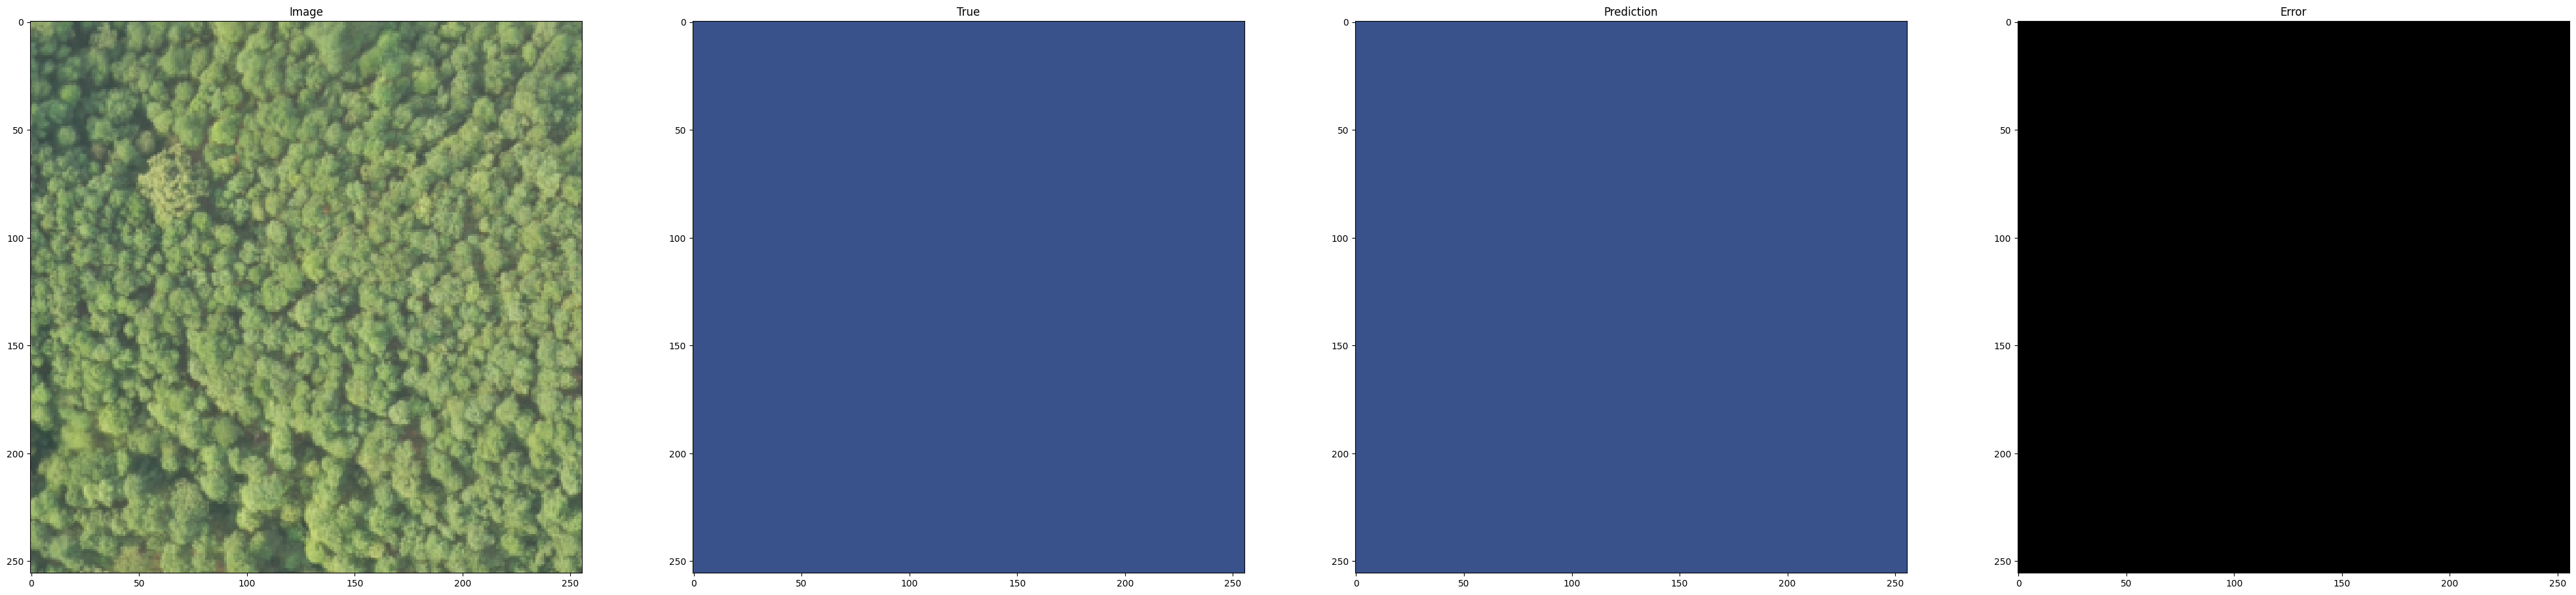

In [68]:
vmin = 0
vmax = 4

for i in range(15):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')

    # print(prediction.shape)
    # print(prediction)
    # print(true.shape)
    # print(true)


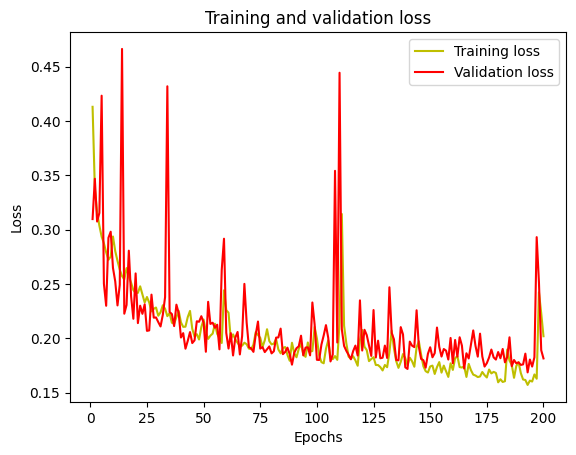

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

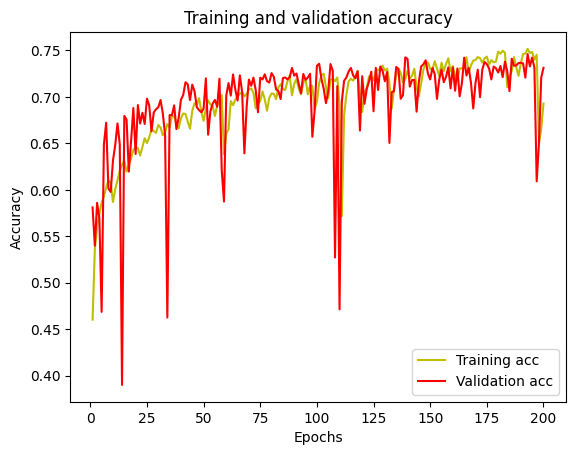

In [60]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
# model.save('unet_model_with_focal_loss_resnet34_backbone.keras')

In [69]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 [==============================] - 0s 9ms/step


In [70]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [71]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [72]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8618734929474733
IoU for class 1 : 0.8778990668125219
IoU for class 2 : 0.9188665709652115
IoU for class 3 : 0.5759895720751701
IoU for class 4 : 0.7190140819649052


In [73]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.7907285569530564
